Initial launch parameters:
::::::::::::::::::::::::::::
* Ball 1:
    -Position: [0, 0]
    -Velocity: 45 m/s at 45 degrees
* Ball 2:
    -Position: [0, 10]
    -Velocity: 45 m/s at 60 degrees

Time interval (dt): 0.1 
Total simulation time: 10

Observation Noise covariances (R):
[[0.5 0. ]
 [0.  0.5]]

State covariance:
[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  0 10  0]
 [ 0  0  0 10]]

Process Noise Covariance (Transition Covariance - Q):
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
---------------------------------------------------
STEP 0:

Observation for ball 1: [2.21190914 3.12677771]
True State for ball 1: [3.18198052 3.08388052]
Filtered Estimate for ball 1: [2.30748722 3.10053063]
............................................................
Observation for ball 2: [ 1.37123082 14.34738092]
True State for ball 2: [ 2.25       13.79901432]
Filtered Estimate for ball 2: [ 0.93011503 15.18638882]

STEP 1:

Observation for ball 1: [7.04899594 7.22621471]
True State for ball 1: [6.363961

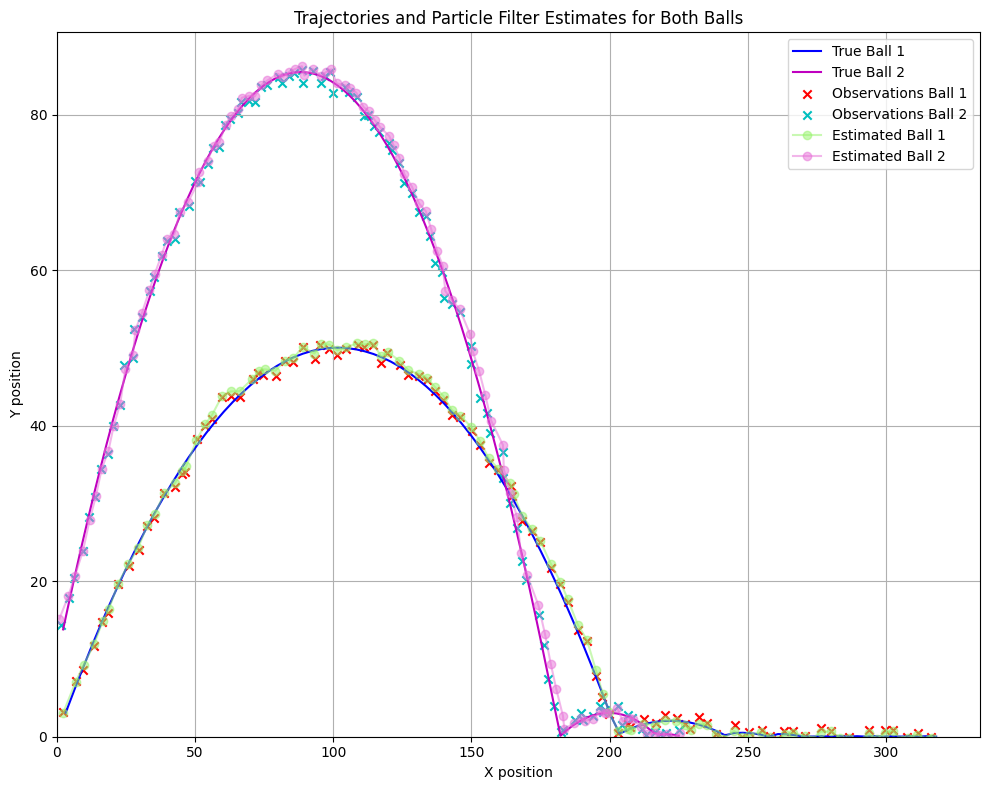

Total time taken: 56.07 seconds


In [1]:
import numpy as np  # imported numpy library for numerical operations
import matplotlib.pyplot as plt  # imported matplotlib library for plotting
import time # to calculate  the runtime

# Record the start time
start_time = time.time()

# function to initialize the ball with initial parameters.
def initialize_ball(launch_position, launch_speed, launch_angle, gravity=-9.81):
    ball = {
        'position': np.array(launch_position, dtype=float),  # initialize position vector
        'velocity': launch_speed * np.array([np.cos(np.deg2rad(launch_angle)), np.sin(np.deg2rad(launch_angle))], dtype=float),  # calculated initial velocity vector
        'gravity': np.array([0, gravity], dtype=float),  # gravity vector
        'time': 0  # initial time
    }
    return ball  # returns initialized ball dictionary

# function to update the ball's state(position and  velocity) after a time step
def step_ball(ball, dt):
    ball['velocity'] += ball['gravity'] * dt  # update velocity due to gravity
    ball['position'] += ball['velocity'] * dt  # update position based on updated velocity
    if ball['position'][1] < 0:
        ball['position'][1] = -ball['position'][1]  # bounce position if ball hits the ground
        ball['velocity'][1] *= -0.2  # decreased velocity due to ground interaction

# function to get the current position of the ball
def get_ball_position(ball):
    return ball['position'].copy()  # returns a copy of the ball's position

# function to generate noisy observation of the true position
def generate_noisy_observation(true_position, observation_noise_cov):
    return true_position + np.random.multivariate_normal([0, 0], observation_noise_cov)  # added noise to true position

# function to initialize particles for the particle filter
def initialize_particle_filter(num_particles, init_state_mean, init_state_cov, transition_cov, observation_cov):
    particles = np.random.multivariate_normal(init_state_mean, init_state_cov, num_particles)  # initialize particles
    weights = np.ones(num_particles) / num_particles  # initialize weights uniformly
    return particles, weights, transition_cov, observation_cov  # return initialized values

# function to predict particles' positions for the next time step
def predict_particles(particles, transition_cov, dt):
    for i in range(len(particles)):
        noise = np.random.multivariate_normal([0, 0, 0, 0], transition_cov)  # generate process noise
        particles[i, 0] += particles[i, 2] * dt + noise[0]  # updated x position
        particles[i, 1] += particles[i, 3] * dt + noise[1]  # updated y position
        particles[i, 2] += noise[2]  # updated x velocity
        particles[i, 3] += noise[3]  # updated y velocity

# function to update weights of particles based on observation
def update_weights(particles, weights, observation, observation_cov):
    for i in range(len(particles)):
        diff = observation - particles[i, :2]  # compute difference between observation and particle position
        weights[i] *= np.exp(-0.5 * diff.T @ np.linalg.inv(observation_cov) @ diff)  # updated weight based on difference

    weights += 1.e-300  # add a small value to avoid division by zero
    weights /= sum(weights)  # Normalize weights

# function to perform systematic resampling of particles if necessary
def resample_particles(particles, weights, num_particles):
    neff = 1. / np.sum(np.square(weights))  # compute effective number of particles
    if neff < num_particles / 2:
        indices = np.random.choice(range(num_particles), num_particles, p=weights)  # Resample indices based on weights
        particles = particles[indices]  # updated particles based on resampling
        weights = np.ones(num_particles) / num_particles  # Reset weights uniformly

    return particles, weights  # returned resampled particles and weights

# function to estimate state from particles using weighted average
def estimate_state(particles, weights):
    return np.average(particles, weights=weights, axis=0)  # returned weighted average state

# function to simulate and filter the trajectory of two balls using particle filters
def simulate_and_filter(dt, total_time, observation_noise_cov, launch_params1, launch_params2,
                        num_particles, init_state_mean, init_state_cov, transition_cov):
    ball1 = initialize_ball(**launch_params1)  # initialized ball 1
    ball2 = initialize_ball(**launch_params2)  # initialized ball 2

    observation_cov = observation_noise_cov  # set observation covariance

    particles1, weights1, _, _ = initialize_particle_filter(num_particles, init_state_mean, init_state_cov, transition_cov, observation_cov)  # initialized particles and weights for ball 1
    particles2, weights2, _, _ = initialize_particle_filter(num_particles, init_state_mean, init_state_cov, transition_cov, observation_cov)  # initialized particles and weights for ball 2

    # printed initial launch parameters and simulation settings
    print("Initial launch parameters:")
    print("::::::::::::::::::::::::::::")
    print(f"* Ball 1:")
    print(f"    -Position: {launch_params1['launch_position']}")
    print(f"    -Velocity: {launch_params1['launch_speed']} m/s at {launch_params1['launch_angle']} degrees")
    print(f"* Ball 2:")
    print(f"    -Position: {launch_params2['launch_position']}")
    print(f"    -Velocity: {launch_params2['launch_speed']} m/s at {launch_params2['launch_angle']} degrees")

    print(f"\nTime interval (dt): {dt} \nTotal simulation time: {total_time}")
    print(f"\nObservation Noise covariances (R):")
    print(observation_noise_cov)
    print(f"\nState covariance:")
    print(init_state_cov)
    print(f"\nProcess Noise Covariance (Transition Covariance - Q):")
    print(transition_cov)
    print("---------------------------------------------------")

    positions1 = []  # list to store true positions of ball 1
    positions2 = []  # list to store true positions of ball 2
    estimated_positions1 = []  # list to store estimated positions of ball 1
    estimated_positions2 = []  # list to store estimated positions of ball 2
    observations1 = []  # list to store noisy observations of ball 1
    observations2 = []  # list to store noisy observations of ball 2

    # simulation loop over time steps
    for step, t in enumerate(np.arange(0, total_time, dt)):
        step_ball(ball1, dt)  # Move ball 1
        step_ball(ball2, dt)  # Move ball 2

        true_position1 = get_ball_position(ball1)  # get true position of ball 1
        true_position2 = get_ball_position(ball2)  # get true position of ball 2

        observation1 = generate_noisy_observation(true_position1, observation_noise_cov)  # generate noisy observation for ball 1
        observation2 = generate_noisy_observation(true_position2, observation_noise_cov)  # generate noisy observation for ball 2

        predict_particles(particles1, transition_cov, dt)  # predicted particles' positions for ball 1
        update_weights(particles1, weights1, observation1, observation_cov)  # updated weights based on observation for ball 1
        particles1, weights1 = resample_particles(particles1, weights1, num_particles)  # Resample particles for ball 1
        estimated_position1 = estimate_state(particles1, weights1)  # estimated state using weighted average for ball 1

        predict_particles(particles2, transition_cov, dt)  # predicted particles' positions for ball 2
        update_weights(particles2, weights2, observation2, observation_cov)  # updated weights based on observation for ball 2
        particles2, weights2 = resample_particles(particles2, weights2, num_particles)  # Resample particles for ball 2
        estimated_position2 = estimate_state(particles2, weights2)  # estimated state using weighted average for ball 2

        # store data for visualization and analysis
        positions1.append(true_position1)
        positions2.append(true_position2)
        estimated_positions1.append(estimated_position1[:2])
        estimated_positions2.append(estimated_position2[:2])
        observations1.append(observation1)
        observations2.append(observation2)

        # printed step information
        print(f"STEP {step}:\n")
        print(f"Observation for ball 1: {observation1}")
        print(f"True State for ball 1: {true_position1}")
        print(f"Filtered Estimate for ball 1: {estimated_position1[:2]}")
        print("............................................................")

        print(f"Observation for ball 2: {observation2}")
        print(f"True State for ball 2: {true_position2}")
        print(f"Filtered Estimate for ball 2: {estimated_position2[:2]}\n")
        print("============================================================")

    # convert lists to numpy arrays for further processing
    positions1 = np.array(positions1)
    positions2 = np.array(positions2)
    estimated_positions1 = np.array(estimated_positions1)
    estimated_positions2 = np.array(estimated_positions2)
    observations1 = np.array(observations1)
    observations2 = np    .array(observations2)

    return positions1, estimated_positions1, positions2, estimated_positions2, observations1, observations2  # returned simulation results

# function to calculate mean squared error (MSE) and root mean squared error (RMSE)
def calculate_errors(true_positions, estimated_positions):
    errors = true_positions - estimated_positions  # compute errors
    mse = np.mean(errors**2)  # calculated MSE
    rmse = np.sqrt(mse)  # calculated RMSE
    return mse, rmse  # returned MSE and RMSE

# function to plot simulation results
def plot_results(positions_true1, estimated_positions1, observations1, positions_true2, estimated_positions2, observations2):
    plt.figure(figsize=(10, 8))  # set figure size

    # Plot true trajectories
    plt.plot(positions_true1[:, 0], positions_true1[:, 1], label='True Ball 1', color='b')
    plt.plot(positions_true2[:, 0], positions_true2[:, 1], label='True Ball 2', color='m')

    # Plot noisy observations
    plt.scatter(observations1[:, 0], observations1[:, 1], color='r', marker='x', label='Observations Ball 1')
    plt.scatter(observations2[:, 0], observations2[:, 1], color='c', marker='x', label='Observations Ball 2')

    # Plot estimated trajectories
    plt.plot(estimated_positions1[:, 0], estimated_positions1[:, 1], color='#95F369', marker='o', label='Estimated Ball 1', alpha=0.5)
    plt.plot(estimated_positions2[:, 0], estimated_positions2[:, 1], color='#E76FD7', marker='o', label='Estimated Ball 2', alpha=0.5)

    plt.xlim([0, None])  # set x-axis limits
    plt.ylim([0, None])  # set y-axis limits

    plt.legend()  # displayed legend
    plt.xlabel('X position')  # label x-axis
    plt.ylabel('Y position')  # label y-axis
    plt.title('Trajectories and Particle Filter Estimates for Both Balls')  # set plot title
    plt.grid(True)  # displayed grid

    plt.tight_layout()  # adjust layout
    plt.show()  # displayed plot

# simulation parameters
dt = 0.1  # time step for simulation
total_time = 10  # total simulation time
observation_noise_cov = np.diag([0.5, 0.5])  # Observation noise covariance matrix

# launch parameters for ball 1 and ball 2
launch_params1 = {'launch_position': [0, 0], 'launch_speed': 45, 'launch_angle': 45}
launch_params2 = {'launch_position': [0, 10], 'launch_speed': 45, 'launch_angle': 60}

# Particle filter parameters
num_particles = 1000  # Number of particles
init_state_mean = [0, 0, 50* np.cos(np.deg2rad(45)), 50 * np.sin(np.deg2rad(45))]  # initialized state mean [x, y, vx, vy]
init_state_cov = np.diag([10, 10, 10, 10])  # initialized state covariance matrix
transition_cov = np.diag([1, 1, 1, 1])  # transition covariance matrix

# simulate and filter trajectory of both balls using particle filters
true_positions1, estimated_positions1, true_positions2, estimated_positions2, observations1, observations2 = simulate_and_filter(dt, total_time, observation_noise_cov,
                                                                                                 launch_params1, launch_params2,
                                                                                                 num_particles, init_state_mean,
                                                                                                 init_state_cov, transition_cov)

# calculated errors for both balls
mse1, rmse1 = calculate_errors(true_positions1[:, :2], estimated_positions1)
mse2, rmse2 = calculate_errors(true_positions2[:, :2], estimated_positions2)

# printed errors for both balls
print(f"Ball 1 - MSE: {mse1:.4f}, RMSE: {rmse1:.4f}")
print(f"Ball 2 - MSE: {mse2:.4f}, RMSE: {rmse2:.4f}")

# plot simulation results
plot_results(true_positions1, estimated_positions1, observations1, true_positions2, estimated_positions2, observations2)

# record the end time
end_time = time.time()

# calculate the total time taken
total_time = end_time - start_time

# print the start time, end time, and total time taken
print(f"Total time taken: {total_time:.2f} seconds")